In [1]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [3]:
read_as_pd("./solutions/1.results.json").columns

Loaded dataframe ./solutions/1.results.json
Executed on: ['algry01' 'algry02']
During: 2021-05-21 14:37:25.626364 and 2021-06-01 01:37:18.179121


Index(['instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'solver', 'solution', 'i', 'coverage', 'touring_cost',
       'length', 'turn_sum', 'turn_factor'],
      dtype='object')

In [4]:
tables = []
for f in os.listdir("./solutions"):
    if not f.startswith("75."):
        continue
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.dropna(inplace=True)

Loaded dataframe ./solutions/75.results.json
Executed on: ['algry01' 'algry02']
During: 2021-05-21 09:56:32.369542 and 2021-05-30 23:12:51.253141


In [5]:
data["type"] = data["solver"].apply(lambda s: "hex" if "Hex" in s else "square")
data["point_based"] = data["solver"].apply(lambda s: "pb=True" in s)

In [6]:
instance_paths = list(data["instance_path"].unique())
instances = [PolygonInstance.from_json(file_path=f) for f in instance_paths]
instance_areas = pd.DataFrame(
    data={"area": [i.original_area.area for i in instances]}, index=instance_paths
)
data = data.merge(instance_areas, left_on="instance_path", right_index=True)

In [7]:
t_ = data.groupby("instance")[["touring_cost"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_cost"] = data["touring_cost"] / data["touring_cost_min"]
data["relative_coverage"] = data["coverage"] / data["area"]

In [8]:
instances = data["instance"].unique()
instance_data = data[data["instance"] == instances[0]]

In [9]:
instance_data.groupby(["type", "point_based"])["relative_cost"].describe()

count      mean       std       min       25%       50%  \
type   point_based                                                            
hex    False         31.0  1.321669  0.266108  1.000000  1.121547  1.266630   
       True          11.0  1.635952  0.156993  1.384828  1.522563  1.710768   
square False         31.0  1.502024  0.247596  1.037592  1.352326  1.485276   
       True          11.0  1.880806  0.338660  1.468342  1.538770  1.900792   

                         75%       max  
type   point_based                      
hex    False        1.502540  1.872898  
       True         1.726664  1.804198  
square False        1.558632  2.026579  
       True         2.170974  2.373689

In [10]:
instance_data.groupby(["type", "point_based"])["relative_coverage"].describe()

count      mean       std       min       25%       50%  \
type   point_based                                                            
hex    False         31.0  0.898728  0.015633  0.876086  0.887696  0.890920   
       True          11.0  0.919162  0.002394  0.916260  0.917807  0.918166   
square False         31.0  0.899439  0.020725  0.873581  0.884646  0.887922   
       True          11.0  0.924831  0.004559  0.914990  0.922728  0.926900   

                         75%       max  
type   point_based                      
hex    False        0.917103  0.926721  
       True         0.920506  0.923198  
square False        0.925190  0.933066  
       True         0.928007  0.929858

Turn Cost: 50.0


<Figure size 432x288 with 0 Axes>

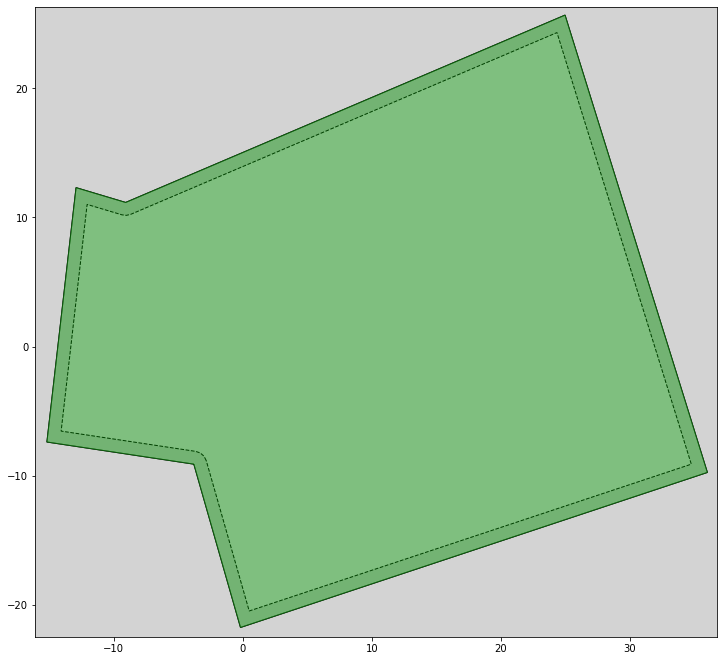

In [11]:
instance = PolygonInstance.from_json(file_path=instance_data.iloc[0]["instance_path"])
print("Turn Cost:", instance.turn_cost)

ax = setup_plot(figsize=(10, 10))
plot_polygon_instance(ax, instance)
plt.show()

In [12]:
def plot(row, path=None):
    solution = Solution.from_json(data=row["solution"])
    ax = setup_plot(figsize=(4.5, 4.5))
    plot_polygon_instance(ax, instance)
    plot_solution(ax, solution)
    plot_coverage(ax, instance, solution)
    plt.title(
        f"Cost: {round(row['touring_cost'],2)}, Coverage: {round(100*row['relative_coverage'],1)}%"
    )
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

# The cheapest solutions for all instance types

('hex', False)
3566.4417327935353 1327.0410513063268 739.008344562718 56.54866776461635
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

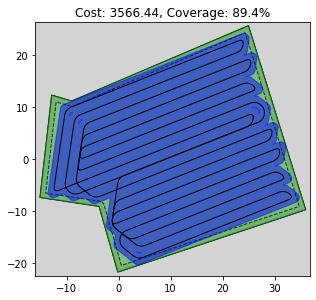

('hex', True)
4938.906841940243 1365.3992023813735 959.5561473931505 79.58701389094185
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

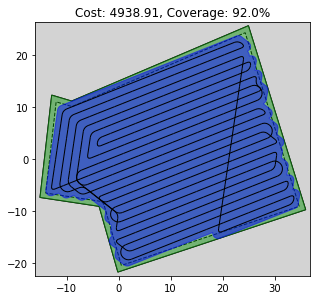

('square', False)
3700.513020910311 1317.09238789593 716.0 59.690260418206236
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

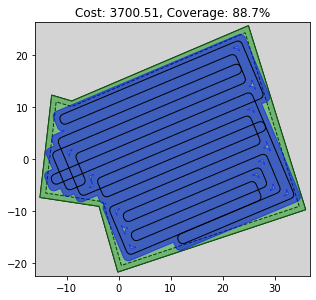

('square', True)
5236.756430256907 1366.078634943839 995.6063479106658 84.82300164692475
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

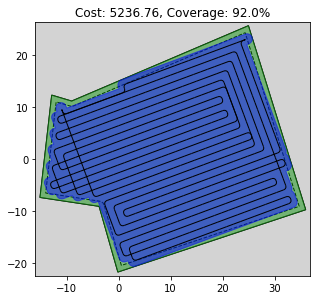

In [13]:
t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].min()
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    print(i)
    print(row["touring_cost"], row["coverage"], row["length"], row["turn_sum"])
    plot(
        row,
        f"./output/example_min_{row['type']}_{'pb' if row['point_based'] else 'lb'}.pdf",
    )

# The median solutions for all instance types

('hex', False)
4517.360426511977 1316.1894740896653 852.1689973238839 73.30382858376186
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

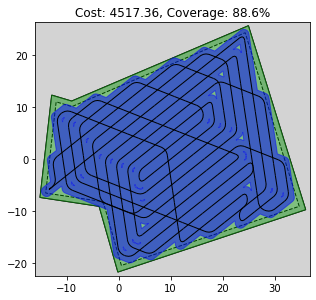

('hex', True)
6101.355090578416 1363.8826704938597 1179.526599954393 98.43656981248046
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

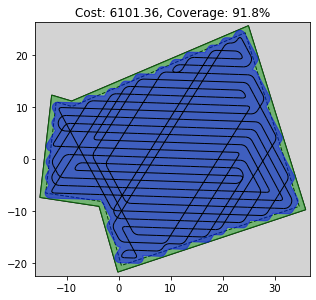

('square', False)
5297.150082346229 1329.6385786821127 1056.0 84.82300164692452
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

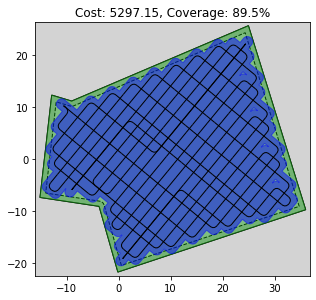

('square', True)
6779.0646312921945 1376.9881075180147 1281.277487510033 109.9557428756431
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

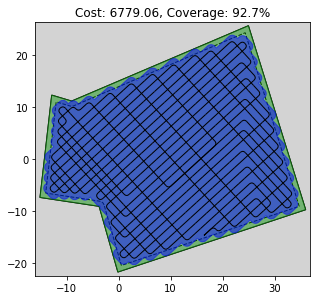

In [14]:
t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].median()
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    print(i)
    print(row["touring_cost"], row["coverage"], row["length"], row["turn_sum"])
    plot(
        row,
        f"./output/example_median_{row['type']}_{'pb' if row['point_based'] else 'lb'}.pdf",
    )

# The worst solutions for all instance types

('hex', False)
6679.582785353402 1376.1163333677275 1338.8752742507265 106.81415022205354
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

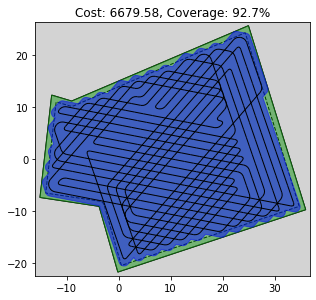

('hex', True)
6434.566914820652 1368.3764236050868 1198.5791588376503 104.71975511966005
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

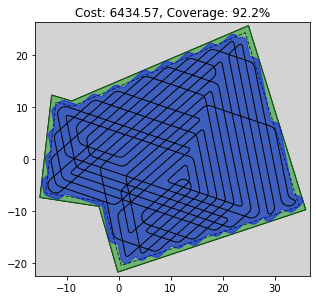

('square', False)
7227.676112332684 1372.5216523996844 1258.6500705120634 119.38052083641223
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

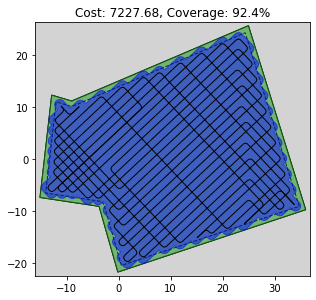

('square', True)
8465.622615689528 1380.7747311822293 1711.1984104714575 135.0884841043612
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

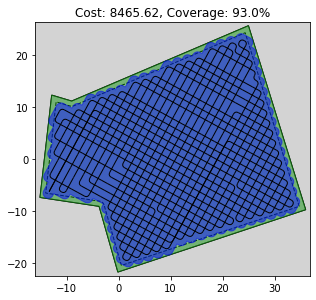

In [15]:
t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].max()
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    print(i)
    print(row["touring_cost"], row["coverage"], row["length"], row["turn_sum"])
    plot(
        row,
        f"./output/example_max_{row['type']}_{'pb' if row['point_based'] else 'lb'}.pdf",
    )

Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon


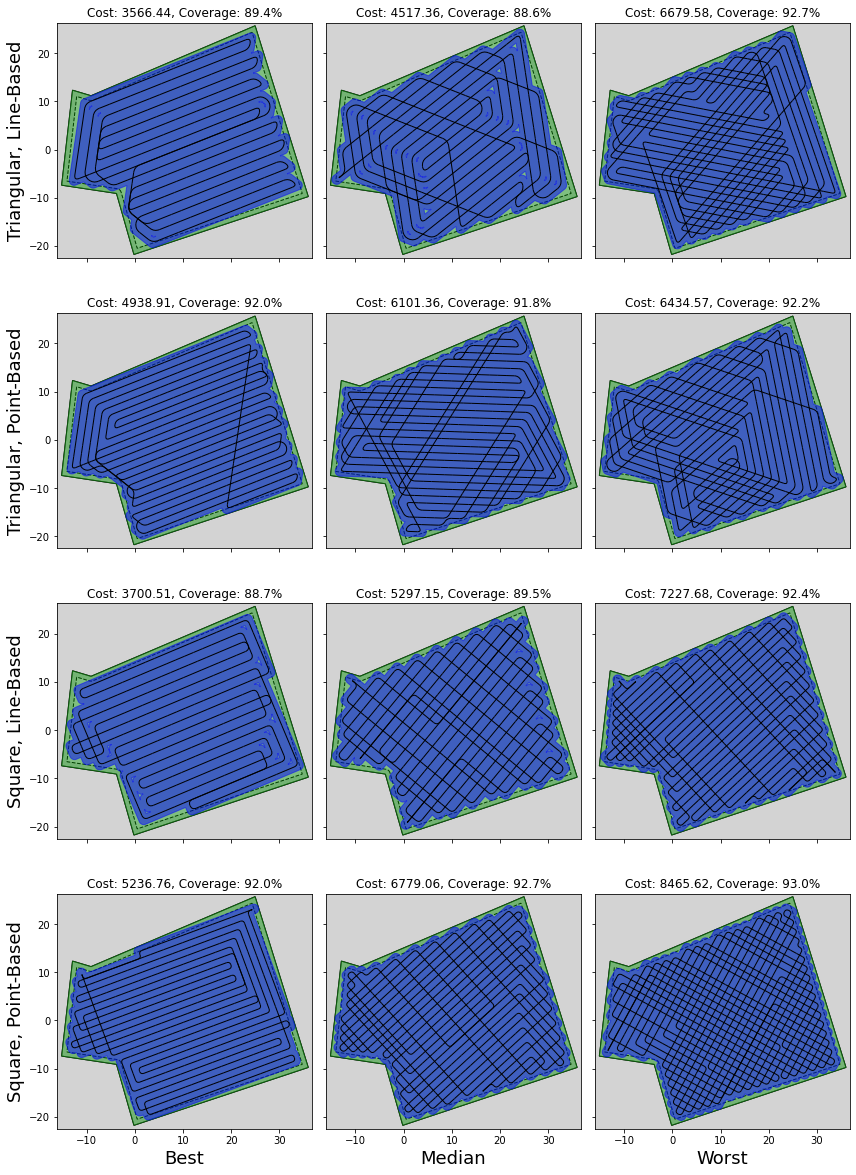

In [16]:
fig, ax = plt.subplots(4, 3, sharex="col", sharey="row", figsize=(12, 17))
plt.tight_layout()


def _plot(row, ax):
    ax.set_aspect("equal", adjustable="box")
    solution = Solution.from_json(data=row["solution"])
    plot_polygon_instance(ax, instance)
    plot_solution(ax, solution)
    plot_coverage(ax, instance, solution)
    ax.set_title(
        f"Cost: {round(row['touring_cost'],2)}, Coverage: {round(100*row['relative_coverage'],1)}%"
    )


t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].min()
i_ = 0
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    _plot(row, ax[i_, 0])
    i_ += 1

t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].median()
i_ = 0
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    _plot(row, ax[i_, 1])
    i_ += 1

t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].max()
i_ = 0
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    _plot(row, ax[i_, 2])
    i_ += 1

ax[0, 0].set_ylabel("Triangular, Line-Based", fontsize=18)
ax[1, 0].set_ylabel("Triangular, Point-Based", fontsize=18)
ax[2, 0].set_ylabel("Square, Line-Based", fontsize=18)
ax[3, 0].set_ylabel("Square, Point-Based", fontsize=18)
ax[3, 0].set_xlabel("Best", fontsize=18)
ax[3, 1].set_xlabel("Median", fontsize=18)
ax[3, 2].set_xlabel("Worst", fontsize=18)
plt.subplots_adjust(left=0.1, bottom=0.03, right=1.0, top=1.0, wspace=0.05, hspace=0.0)
plt.tight_layout()
plt.savefig("./output/02_minmaxmean.pdf")
plt.show()